## Preparação de dados do TCU
Fernando Melo - 10/09/2018
Ajuste Borela 14/9/18
   . treinamento LM usando toda a base de textos (melhorou perplexidade)
   . usando modelo pretreinado da Monique com cerca de 10 mil palavras
   . classificador com resultado semelhante à 1a versão do Fernando

Dados disponíveis no site: https://contas.tcu.gov.br/pesquisaJurisprudencia/#/pesquisa/jurisprudencia-selecionada

In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Random permutation of train and test texts
np.random.seed(42)

In [3]:
from fastai.text import *
import html


/home/borela/anaconda3/envs/fastai/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
import spacy
nlp = spacy.load('pt')

In [5]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Reading data 

In [6]:
# set path for classification files
CLAS_PATH=Path('data/tcu/dist_class')
CLAS_PATH.mkdir(exist_ok=True)

# set path for language model files
LM_PATH=Path('data/tcu/dist_lm/')
LM_PATH.mkdir(exist_ok=True)

PATH = 'data/tcu/'

In [7]:
df = pd.read_csv(PATH+'tcu_jurisp.csv', index_col=0) 

In [6]:
df.shape

(13258, 2)

In [10]:
df.head()

,labels,text
0,6,O TCU tem competência para fiscalizar a aplica...
1,6,"Não compete ao TCU apreciar, para fins de regi..."
2,6,Compete ao TCU a apreciação da constitucionali...
3,6,É possível a expedição de determinação pelo TC...
4,6,"O TCU não tem competência, no âmbito do Progra..."


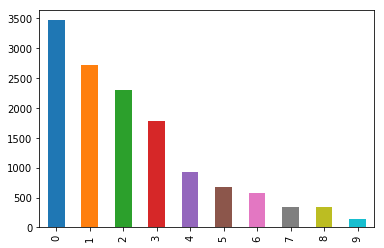

In [11]:
df['labels'].value_counts().plot.bar()

In [12]:
df['labels'].value_counts()

0    3468
1    2723
2    2297
3    1775
4     932
5     673
6     572
7     343
8     337
9     138
Name: labels, dtype: int64

In [13]:
# save new file distribuicao.csv for future use
df.to_csv(PATH+'distrib.csv')

In [14]:
df.head()

,labels,text
0,6,O TCU tem competência para fiscalizar a aplica...
1,6,"Não compete ao TCU apreciar, para fins de regi..."
2,6,Compete ao TCU a apreciação da constitucionali...
3,6,É possível a expedição de determinação pelo TC...
4,6,"O TCU não tem competência, no âmbito do Progra..."


## Spliting data in train and test datasets for CLASSIFICATION ONLY

In [15]:
df_reduz = pd.read_csv(PATH+'tcu_jurisp_reduzido.csv', index_col=0)

In [16]:
df_reduz.shape

(10263, 2)

In [18]:
df_reduz['labels'].value_counts()

0    3468
1    2723
2    2297
3    1775
Name: labels, dtype: int64

Testar dividir com balanceamento de classes nos 2 conjuntos

In [19]:
train,test = train_test_split(df_reduz, test_size=0.1)

In [20]:
# save train and test of tcu_jurisp.csv for future use
# test dataset will have 10%  of the total rows of the orginal dataset.
test.to_csv(PATH+'test_tcu_jurisp.csv')
train.to_csv(PATH+'train_tcu_jurisp.csv')

In [21]:
test.shape

(1027, 2)

In [22]:
train.shape

(9236, 2)

## Classification data preparation

In [8]:
CLASSES = ['Pessoal', 'Licitação', 'Responsabilidade','Direito_Processual']

In [27]:
# Append texts and labels from TRAIN dataset and create numpy array
trn_texts = np.array(train['text'])
trn_labels = np.array(train['labels']le)
# Append texts and labels from TEST dataset and create numpy array
val_texts = np.array(test['text'])
val_labels = np.array(test['labels'])


In [28]:
len(trn_texts), len(val_texts)

(9236, 1027)

In [29]:
trn_texts[0:10]

array(['As funções de confiança dos conselhos de fiscalização profissional devem ser exclusivamente ocupadas por empregados do quadro efetivo. Os seus cargos em comissão, a serem preenchidos por empregados do quadro efetivo nas condições e limites mínimos a serem fixados por instruções dos conselhos federais, devem ser destinados apenas às atribuições de direção, chefia e assessoramento, uma vez que as disposições do art. 37, inciso V, da Constituição Federal aplicam-se a essas entidades.',
       'Nos processos de controle externo, a decisão que trata de matéria de ordem pública (requisitos de admissibilidade, pressupostos processuais, condições da ação, prescrição, decadência) pode ser revista de ofício ou mediante provocação da parte por simples petição, independentemente de recurso, não incidindo a preclusão pro judicato. ',
       'A redistribuição por reciprocidade é condenável por configurar a transferência, instituto banido da legislação pátria desde 1995, por meio de decisão e

In [30]:
trn_labels[0:10]

array([0, 3, 0, 2, 3, 3, 1, 1, 0, 0])

In [31]:
col_names = ['labels','text']

Random permutation np array to shuffle the text.  
Text and labels have to be permutated in the same way and that's why we're going to set the seed.

In [32]:
# Random permutation of train and test texts
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [34]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [35]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [36]:
df_val.head()

,labels,text
0,2,"O TCU, utilizando-se do juízo discricionário c..."
1,0,No caso de conversão do provento proporcional ...
2,0,As pensões concedidas aos beneficiários de ex-...
3,3,Arquiva-se o processo quando o valor atualizad...
4,3,A contradição que se pretende sanar pela via d...


The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns.

In [37]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

## Language model data preparation

Creating the data for the Language Model(LM). The LM's goal is to learn the structure of the portuguese language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.

The LM can benefit from all the textual data and there is no need to exclude text.

In [38]:
df_text = np.array(df.text)

In [39]:
df_text.shape

(13258,)

In [40]:
# trn_texts,val_texts = sklearn.model_selection.train_test_split(
#     np.concatenate([trn_texts,val_texts]), test_size=0.1)

trn_texts,val_texts = train_test_split(df_text, test_size=0.1)

In [41]:
len(trn_texts), len(val_texts)

(11932, 1326)

In [42]:
len(trn_texts)

11932

In [43]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language model tokenization

In [44]:
chunksize=2000

In [45]:
import re

In [46]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [47]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer(lang='pt').proc_all_mp(partition_by_cores(texts),lang='pt')
    return tok, list(labels)

In [48]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [5]:
!cat ~/fastai/courses/dl2/fastai/text.py

from .core import *
from .learner import *
from .lm_rnn import *
from torch.utils.data.sampler import Sampler
import spacy
from spacy.symbols import ORTH

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

def texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    return texts, np.array(labels).astype(np.int64)

def numericalize_tok(tokens, max_vocab=50000, min_freq=0, unk_tok="_unk_", pad_tok="_pad_", bos_tok="_bos_", eos_tok="_eos_"):
    """Takes in text tokens and returns int2tok and tok2int converters

        Arguments:
        tokens(list): List of tokens. Can be a list of strings, or a list of lists of strings.
        max_vocab(int): Number of tokens to return in the vocab (sorted by frequency)
        min_freq

In [49]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [50]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
0


In [51]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [52]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [53]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [54]:
tok_trn.shape

(11932,)

Linha adicionada - Borela 

In [61]:
tok_total = np.concatenate((tok_trn, tok_val), axis=0)

In [62]:
tok_total.shape

(13258,)

In [64]:
freq = Counter(p for o in tok_total for p in o)
freq.most_common(25)

[('de', 43000),
 (',', 41289),
 ('a', 31723),
 ('.', 19683),
 ('o', 16950),
 ('da', 15852),
 ('do', 14374),
 ('1', 13416),
 ('\n', 13258),
 ('xbos', 13258),
 ('xfld', 13258),
 ('e', 11712),
 ('que', 9256),
 ('em', 7946),
 ('não', 7778),
 ('/', 7337),
 ('para', 6550),
 ('os', 5996),
 ('t_up', 5953),
 ('no', 5483),
 ('se', 4941),
 ('ou', 4900),
 ('com', 4836),
 ('à', 4782),
 ('dos', 4616)]

In [65]:
freq

Counter({'\n': 13258,
         'xbos': 13258,
         'xfld': 13258,
         '1': 13416,
         'o': 16950,
         'cargo': 741,
         'em': 7946,
         'comissão': 309,
         'de': 43000,
         'consultor': 7,
         'jurídico': 264,
         'dos': 4616,
         'ministérios': 4,
         'é': 4611,
         'livre': 31,
         'nomeação': 60,
         'do': 14374,
         'presidente': 40,
         'da': 15852,
         'república': 25,
         ',': 41289,
         'com': 4836,
         'as': 2803,
         'delegações': 1,
         'devidas': 45,
         '(': 3069,
         'art': 3661,
         '.': 19683,
         '49': 12,
         'inciso': 1160,
         'ii': 477,
         'c': 302,
         '/': 7337,
         '58': 152,
         'lei': 4521,
         'complementar': 260,
         '73': 15,
         '1993': 968,
         ')': 3322,
         'ressalvados': 13,
         'esse': 395,
         'e': 11712,
         'os': 5996,
         'demais': 170,
   

O dicionário aumentou de 14997 para 15490 palavras ao considerar tok_total ao invés de tok_trn (Borela)

In [66]:
len(freq)

15490

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [67]:
max_vocab = 60000
min_freq = 2

Possível variação - trocar min_freq para 1 (Borela)

In [68]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [69]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8603

297 (8603-8306) palavras a mais após filtro de mínimo de ocorrências! (Borela)

In [71]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [72]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [9]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

Passo para rexecução 

In [10]:
vs=len(itos)
vs,len(trn_lm)

(8603, 11932)

In [75]:
' '.join(tok_trn[0]+tok_trn[1]+tok_trn[2]+tok_trn[3]+tok_trn[4])

'\n xbos xfld 1 o cargo em comissão de consultor jurídico dos ministérios é de livre nomeação do presidente da república , com as delegações devidas ( art . 49 , inciso ii , c / c art . 58 da lei complementar 73 / 1993 ) . ressalvados esse e os demais cargos de livre nomeação expressamente previstos em lei , o exercício das atividades de consultoria e assessoramento jurídico dos órgãos do poder executivo compete exclusivamente a os membros das carreiras da advocacia - geral da união . \n xbos xfld 1 o tempo de serviço relativo a o regime geral de previdência social , ainda que prestado a órgão ou entidade da administração federal , estadual e municipal , é comprovado mediante certidão emitida pelo instituto nacional do seguro social . \n xbos xfld 1 o instituto da solidariedade passiva é um benefício conferido pelo legislador ordinário a o credor , que pode exigir de um ou de algum dos devedores , parcial ou totalmente , o pagamento da integralidade da dívida , assistindo a o devedor q

In [76]:
' '.join(str(o) for o in trn_lm[0:4])

'[10, 11, 12, 9, 6, 86, 15, 259, 2, 5152, 293, 26, 6601, 27, 2, 2146, 1306, 8, 1778, 7, 2484, 3, 24, 36, 0, 1634, 35, 32, 5, 3880, 3, 54, 154, 3, 263, 17, 263, 32, 5, 555, 7, 28, 298, 3397, 17, 66, 34, 5, 3698, 200, 13, 19, 488, 177, 2, 2146, 1306, 568, 358, 15, 28, 3, 6, 94, 37, 255, 2, 3034, 13, 2566, 293, 26, 245, 8, 227, 986, 437, 438, 4, 19, 1044, 37, 1660, 7, 1236, 30, 405, 7, 82, 5] [10, 11, 12, 9, 6, 61, 2, 56, 1177, 4, 6, 125, 405, 2, 422, 248, 3, 122, 14, 432, 4, 107, 23, 123, 7, 44, 51, 3, 1028, 13, 539, 3, 27, 853, 175, 854, 1956, 40, 648, 233, 8, 1889, 248, 5] [10, 11, 12, 9, 6, 648, 7, 1123, 2253, 27, 111, 246, 3699, 40, 4273, 3700, 4, 6, 1557, 3, 14, 64, 378, 2, 111, 23, 2, 1779, 26, 1853, 3, 855, 23, 4805, 3, 6, 74, 7, 1707, 7, 532, 3, 0, 4, 6, 2052, 14, 5993, 4, 532, 29, 3538, 6, 85, 2, 378, 2, 279, 111, 26, 4274, 30, 1853, 4, 53, 5536, 31, 1015, 176, 5] [10, 11, 12, 9, 27, 93, 4, 393, 2, 476, 15, 409, 290, 4, 1141, 419, 3, 60, 53, 393, 185, 1323, 112, 4, 771, 354, 8, 

## Wikipedia model: ptwiki_nandobr conversion

The pre-trained wiki LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target TCU LM so that the weights can be loaded up.

Passo para rexecução 

In [11]:
em_sz,nh,nl = 400,1150,3

PRE_PATH = Path('data/wiki/pt/models/')
PRE_LM_PATH = PRE_PATH/'ptwiki_nandobrbest.h5'
lm_PT_1_cycle_10_epochs_from_scratch

In [99]:
PRE_PATH = Path('data/wikimonique/')
PRE_LM_PATH = PRE_PATH/'lm_PT_1_cycle_10_epochs_from_scratch.h5'


In [100]:
PRE_LM_PATH

PosixPath('data/wikimonique/lm_PT_1_cycle_10_epochs_from_scratch.h5')

In [101]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target TCU LM.

In [102]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [103]:
wgts

OrderedDict([('0.encoder.weight', 
               1.3240e-03  8.9112e-01  2.3996e-02  ...  -3.3010e-02 -5.3667e-02 -3.4263e-01
               6.3987e-02 -9.2508e-02  5.4168e-02  ...   5.1551e-02 -5.8966e-02  1.2346e-01
               1.6228e-02  1.2407e-01 -4.3774e-02  ...  -2.2155e-01  2.9039e-02 -3.3670e-01
                              ...                   ⋱                   ...                
               1.1543e+00  2.0497e-01 -5.9946e-01  ...  -8.5755e-02  1.5822e-01  3.9209e-01
              -4.0879e-01 -2.4324e-01 -1.6323e+00  ...   2.2691e-02 -7.1808e-02  2.5033e-01
               4.0362e-01  1.2450e-01 -7.4910e-01  ...   1.2810e-01 -2.2874e-02 -9.6124e-03
              [torch.FloatTensor of size 30002x400]),
             ('0.encoder_with_dropout.embed.weight', 
               1.3240e-03  8.9112e-01  2.3996e-02  ...  -3.3010e-02 -5.3667e-02 -3.4263e-01
               6.3987e-02 -9.2508e-02  5.4168e-02  ...   5.1551e-02 -5.8966e-02  1.2346e-01
               1.6228e-02  1.

Obtive itos criado pela Monique (apenas 30002 palavras) (Borela)

Variar:
    LM acórdãos
    LM wiki Fernando

In [104]:
itos2 = pickle.load((PRE_PATH/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [106]:
len(itos2)

30002

In [110]:
stoi2['cargo']

731

In [112]:
stoi['cargo']

86

In [113]:
enc_wgts[731]

array([ 0.02287, -0.0283 ,  0.07235, -0.05819,  0.61788, -0.02297,  1.1625 , -0.3665 , -0.72984,  0.56039,
        0.2006 , -0.71571,  0.11325, -0.24594, -0.0833 , -0.18547, -0.18339,  0.67069, -0.11484,  0.86782,
        0.03577, -0.62018, -0.12659,  0.2405 ,  1.067  ,  0.71183, -0.56624, -0.31224, -0.76893,  0.10747,
        0.66052, -0.06077, -0.11484,  1.42003, -0.55274,  0.04556, -0.14471,  0.51881,  0.33958, -0.92951,
        0.72287, -0.14231,  0.28208, -0.55716, -0.14571,  0.02318, -0.45442,  0.40159,  0.7072 , -0.21385,
       -0.44144,  0.12665,  0.00989,  0.40026, -0.02956, -0.09551, -0.46403,  0.3537 , -0.55281, -0.49446,
        0.40107,  0.08432,  0.30999, -0.35782, -1.07522, -0.54994, -0.18407,  0.31361,  1.68348, -0.59116,
       -0.24105, -0.79454,  0.27585, -0.90862, -0.51875,  0.19875,  0.43683, -0.21422, -0.456  ,  0.13524,
       -0.25374, -0.16642,  0.64316,  0.20487,  0.01018,  0.54856, -0.9884 , -0.00371,  0.0661 , -1.05251,
       -0.08413, -0.43797, -0.16194, 

Before we try to transfer the knowledge from wikitext to the TCU LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown Senado tokens that do not exist in ptwiki_nandobr.

Alterei código abaixo para saber qtds (Borela)

In [125]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
qtd_ausente = 0
for i,w in enumerate(itos):
    r = stoi2[w]
    if r>=0:
        new_w[i] = enc_wgts[r]  
    else:
        new_w[i] = row_m
        print('palavra não havia na wiki', i, w, freq[w])
        qtd_ausente += 1
print('qtd ausente:', qtd_ausente)

palavra não havia na wiki 38 tcu 2515
palavra não havia na wiki 72 8.666 865
palavra não havia na wiki 141 proventos 504
palavra não havia na wiki 144 8.112 493
palavra não havia na wiki 161 erário 461
palavra não havia na wiki 172 súmula 438
palavra não havia na wiki 188 8.443 416
palavra não havia na wiki 211 licitante 381
palavra não havia na wiki 247 licitantes 327
palavra não havia na wiki 258 licitatório 312
palavra não havia na wiki 266 acórdão 297
palavra não havia na wiki 315 embargos 253
palavra não havia na wiki 347 pregão 233
palavra não havia na wiki 359 ressarcimento 225
palavra não havia na wiki 365 indevida 222
palavra não havia na wiki 366 responsabilização 220
palavra não havia na wiki 370 gratificação 217
palavra não havia na wiki 374 convenente 214
palavra não havia na wiki 386 instituidor 210
palavra não havia na wiki 414 unitários 198
palavra não havia na wiki 421 concedente 196
palavra não havia na wiki 444 contratante 186
palavra não havia na wiki 468 cabível 17

palavra não havia na wiki 3239 justificados 17
palavra não havia na wiki 3240 expedidas 17
palavra não havia na wiki 3242 orçado 17
palavra não havia na wiki 3264 gradação 16
palavra não havia na wiki 3270 cumulação 16
palavra não havia na wiki 3272 consumação 16
palavra não havia na wiki 3281 repassado 16
palavra não havia na wiki 3283 anuência 16
palavra não havia na wiki 3288 565 16
palavra não havia na wiki 3291 congênere 16
palavra não havia na wiki 3293 fraudulenta 16
palavra não havia na wiki 3294 balizadores 16
palavra não havia na wiki 3296 cotação 16
palavra não havia na wiki 3298 extingue 16
palavra não havia na wiki 3306 sana 16
palavra não havia na wiki 3307 intempestiva 16
palavra não havia na wiki 3308 9.624 16
palavra não havia na wiki 3311 11.784 16
palavra não havia na wiki 3316 monetariamente 16
palavra não havia na wiki 3326 instaurar 16
palavra não havia na wiki 3329 sujeitando 16
palavra não havia na wiki 3330 condão 16
palavra não havia na wiki 3332 deferida 16
p

palavra não havia na wiki 5026 juris 8
palavra não havia na wiki 5027 contestar 8
palavra não havia na wiki 5029 atribua 8
palavra não havia na wiki 5031 extrajudiciais 8
palavra não havia na wiki 5036 computados 8
palavra não havia na wiki 5037 impugnações 8
palavra não havia na wiki 5043 instituídos 8
palavra não havia na wiki 5046 dispêndio 8
palavra não havia na wiki 5048 solteiras 8
palavra não havia na wiki 5049 averiguar 8
palavra não havia na wiki 5058 celeridade 8
palavra não havia na wiki 5061 cpl 8
palavra não havia na wiki 5062 constitucionalmente 8
palavra não havia na wiki 5064 desconstituição 8
palavra não havia na wiki 5068 atenha 8
palavra não havia na wiki 5071 aportes 8
palavra não havia na wiki 5073 incidental 8
palavra não havia na wiki 5074 motivadas 8
palavra não havia na wiki 5075 concessórios 8
palavra não havia na wiki 5078 subseqüentes 8
palavra não havia na wiki 5079 prorrogar 8
palavra não havia na wiki 5081 subsidiário 8
palavra não havia na wiki 5082 fize

palavra não havia na wiki 6517 liame 5
palavra não havia na wiki 6521 labore 5
palavra não havia na wiki 6524 amicus 5
palavra não havia na wiki 6525 curiae 5
palavra não havia na wiki 6530 recebam 5
palavra não havia na wiki 6533 gozada 5
palavra não havia na wiki 6535 laborou 5
palavra não havia na wiki 6536 antecipatório 5
palavra não havia na wiki 6538 contratualmente 5
palavra não havia na wiki 6539 emitentes 5
palavra não havia na wiki 6542 púbicos 5
palavra não havia na wiki 6543 contento 5
palavra não havia na wiki 6546 benfeitorias 5
palavra não havia na wiki 6547 ocasiona 5
palavra não havia na wiki 6549 mensalidades 5
palavra não havia na wiki 6554 proferidas 5
palavra não havia na wiki 6555 errônea 5
palavra não havia na wiki 6561 areais 5
palavra não havia na wiki 6563 advindas 5
palavra não havia na wiki 6565 avaliador 5
palavra não havia na wiki 6566 impositivo 5
palavra não havia na wiki 6569 1.485 5
palavra não havia na wiki 6572 parágrafos 5
palavra não havia na wiki 

palavra não havia na wiki 7962 onerosidade 3
palavra não havia na wiki 7963 pagadora 3
palavra não havia na wiki 7964 licito 3
palavra não havia na wiki 7966 aquisitivos 3
palavra não havia na wiki 7968 decisórios 3
palavra não havia na wiki 7971 apura 3
palavra não havia na wiki 7972 transmuda 3
palavra não havia na wiki 7973 beneficiaram 3
palavra não havia na wiki 7975 moléstias 3
palavra não havia na wiki 7976 inquestionavelmente 3
palavra não havia na wiki 7978 corporativas 3
palavra não havia na wiki 7981 adotá 3
palavra não havia na wiki 7982 273 3
palavra não havia na wiki 7985 mencione 3
palavra não havia na wiki 7986 furtar 3
palavra não havia na wiki 7987 pronunciamentos 3
palavra não havia na wiki 7989 lesivas 3
palavra não havia na wiki 7992 surgidas 3
palavra não havia na wiki 7994 investigadas 3
palavra não havia na wiki 7995 gravosas 3
palavra não havia na wiki 7999 consumidora 3
palavra não havia na wiki 8001 delimitados 3
palavra não havia na wiki 8002 estenda 3
palav

2859 (33%) palavras ausentes: tcu (2515 ocorrências nos documentos a classificar), 8.666 (865), proventos (504), erário (461), súmula(438), licitante(381), pregão (233), etc
(Anotação de Borela)

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [115]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new TCU language pytorch model!

## TCU Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the Senado LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

Passo para rexecução 

In [12]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

Passo para rexecução 

In [45]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

Parâmetro a variar: 0.7 (Borela)

In [14]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [46]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [120]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [16]:
lr=1e-3
lrs = lr

In [122]:
%%time
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      5.140027   4.823876   0.251143  

CPU times: user 1min 4s, sys: 29 s, total: 1min 33s
Wall time: 1min 37s


[array([4.82388]), 0.25114259515938003]

Execução inicial - Fernando

%%time
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))
epoch      trn_loss   val_loss   accuracy                   
    0      5.255032   4.7782     0.238717  

CPU times: user 23.1 s, sys: 5.08 s, total: 28.2 s
Wall time: 29.3 s
[array([4.7782]), 0.23871747757259168]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [126]:
learner.save('lm_last_ft')

In [127]:
learner.load('lm_last_ft')

In [128]:
learner.unfreeze()

In [129]:
%%time
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.567858   3.190472   0.38491   

CPU times: user 1min 31s, sys: 34.9 s, total: 2min 6s
Wall time: 2min 6s


In [34]:
print('Perplexidade = ', np.exp(3.19))

Perplexidade =  24.288427443094555


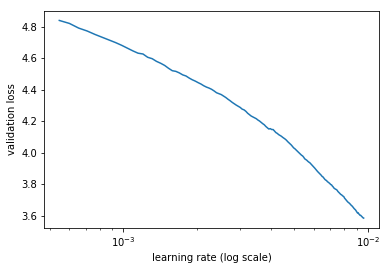

In [130]:
learner.sched.plot()

(versão original Fernando)

%%time
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))
epoch      trn_loss   val_loss   accuracy                   
    0      3.742343   3.287181   0.370196  

CPU times: user 28.9 s, sys: 6.52 s, total: 35.5 s
Wall time: 35.5 s

Variar lrs... de repente começar de 5\* 10\**-2

Avaliar wds=wd

lr=1e-3
lrs = lr

In [131]:
%%time
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      4.158685   3.792073   0.334732  
    1      3.708605   3.40113    0.373842                   
    2      3.398586   3.173406   0.398212                   
    3      3.212806   3.030969   0.413864                   
    4      3.040012   2.928711   0.424469                   
    5      2.937333   2.855683   0.435638                   
    6      2.833585   2.802154   0.443048                   
    7      2.759211   2.753697   0.451127                   
    8      2.693745   2.728137   0.454419                   
    9      2.642773   2.709966   0.457792                   
    10     2.635475   2.680363   0.461109                   
    11     2.552451   2.666249   0.462987                   
    12     2.521901   2.650663   0.466162                   
    13     2.508745   2.651667   0.466172                   
    14     2.499887   2.646118   0.466878                   

CPU times: user 23min 22s, sys: 8min 58s

[array([2.64612]), 0.4668775545923333]

In [35]:
print('Perplexidade = ', np.exp(2.64))

Perplexidade =  14.013203607733615


In [1]:
def what_next(seq, res_len):
    m = learner.model
    # Turn off dropout
    m.eval() # não fez diferença no teste
    # Reset hidden state
    m.reset()  
    tok = Tokenizer().proc_text(seq)
    ids = [stoi[word] for word in tok]
    # print('stoi:', ids, end='\n\n')

    """ deveria mostrar próximas 15 palavras candidatas, mas precisa ser revisto
    proxima_palavra = []
    res,*_ = m(V(T(np.array([ids]))))
    [proxima_palavra.append(itos[o]) for o in to_np(torch.topk(res[-1], 15)[1])]
    print('15 candidatas a proxima_palavra ', proxima_palavra, end='\n\n')
    """
    
    res = []
    for i in ids:
        x = V(np.array(i)).unsqueeze(0)
        preds =m(x)
        val,idx = preds[0].data.max(1)
    for i in range(res_len):
        res.append(idx[0])
        x = V(idx).unsqueeze(0)
        preds = m(x)
        val,idx = preds[0].data.max(1)
    return [itos[i] for i in res]

In [2]:
s="""o cargo em comissão de consultor jurídico dos ministérios é de livre """
print(what_next(s, 12))

NameError: name 'learner' is not defined

(versão original Fernando)
%%time
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)


HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))
epoch      trn_loss   val_loss   accuracy                   
    0      4.346938   3.863956   0.318073  
    1      3.889904   3.513234   0.352266                   
    2      3.614359   3.316463   0.372923                   
    3      3.432717   3.182624   0.387281                   
    4      3.299603   3.090508   0.398573                   
    5      3.19458    3.022937   0.406933                   
    6      3.111347   2.963846   0.415421                   
    7      3.024716   2.917209   0.421194                   
    8      2.976804   2.882251   0.426415                   
    9      2.932255   2.848631   0.431315                   
    10     2.877682   2.828991   0.43471                    
    11     2.862214   2.810855   0.437535                   
    12     2.830114   2.798963   0.439408                   
    13     2.783524   2.792671   0.440428                   
    14     2.782638   2.786632   0.441947                   

CPU times: user 7min 21s, sys: 1min 38s, total: 9min
Wall time: 9min
[array([2.78663]), 0.44194654571382624]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [132]:
learner.save('lm1')

In [133]:
learner.save_encoder('lm1_enc')

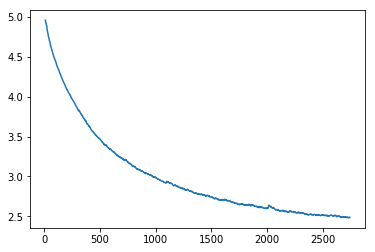

In [134]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [135]:
chunksize=2000

In [136]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [138]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
0


In [141]:
len(tok_trn), len(tok_val)

(9236, 1027)

In [142]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [9]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [17]:
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8603

In [145]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [146]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

In [148]:
trn_clas

array([list([10, 11, 12, 9, 4, 287, 133, 2, 85, 740, 3, 4, 6, 2958, 1029, 24, 6, 227, 49, 51, 3, 24, 571, 2, 1949, 76, 292, 71, 3, 331, 599, 4, 6, 284, 7, 415, 2, 518, 45, 13, 4, 612, 2, 131, 768, 40, 213, 22, 402, 5]),
       list([10, 11, 12, 9, 4, 155, 2, 94, 327, 2, 813, 257, 18, 393, 2, 149, 2, 342, 84, 1669, 36, 1644, 40, 90, 39, 33, 3154, 3, 410, 15, 320, 14, 36, 716, 193, 3163, 17, 541, 13, 193, 3288, 17, 541, 3, 3341, 8, 968, 3, 4, 6, 7062, 4, 408, 18, 96, 14, 6644, 3, 31, 119, 7, 63, 3, 104, 111, 4836, 3562, 3, 6645, 6643, 4, 78, 2, 238, 128, 21, 84, 2, 149, 1821, 29, 1035, 2, 813, 257, 5]),
       list([10, 11, 12, 9, 4, 455, 2, 201, 2, 580, 18, 908, 2, 50, 31, 44, 71, 51, 35, 32, 5, 887, 7, 28, 188, 17, 166, 34, 64, 33, 656, 343, 25, 97, 14, 3, 611, 16, 185, 4711, 7, 50, 3, 5279, 18, 4362, 6, 190, 5]),
       ...,
       list([10, 11, 12, 9, 27, 365, 4, 78, 2, 254, 3, 24, 99, 31, 28, 193, 1953, 17, 2339, 3, 4, 96, 4074, 2218, 4, 6, 125, 7, 20, 1946, 5, 238, 128, 104, 2119, 

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

Passo para rexecução 

In [20]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

Passo para rexecução 

In [19]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

no LM usou bs = 52 (Borela)
optim.Adam...
Variar

Passo para rexecução 

In [18]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

Pegando intervalo de números das classes (Borela)

Passo para rexecução 

In [22]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [23]:
min_lbl, c

(0, 4)

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

Passo para rexecução 

In [24]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

?? Não entendi  2 linhas abaixo (Borela)

In [118]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

Passo para rexecução 

In [25]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

Passo para rexecução 

In [26]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

Passo para rexecução 

In [27]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

Passo para rexecução 

In [28]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

?? lrs setado e valor sobreposto depois

Passo para rexecução 

In [29]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

Passo para rexecução 

In [30]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [25]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [165]:
learn.freeze_to(-1)

(versão original Fernando)
learn.lr_find(lrs/1000)
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))
 78%|███████▊  | 301/385 [00:11<00:03, 26.11it/s, loss=2.41] 



--------------------

%%time
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))
epoch      trn_loss   val_loss   accuracy                    
    0      0.48026    0.301034   0.885102  
CPU times: user 14.7 s, sys: 2.62 s, total: 17.3 s
Wall time: 17.3 s
[array([0.30103]), 0.8851022355280229]


--------------------

%%time
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))
epoch      trn_loss   val_loss   accuracy                    
    0      0.438056   0.263369   0.901655  
CPU times: user 16.6 s, sys: 2.71 s, total: 19.3 s
Wall time: 19.4 s
[array([0.26337]), 0.9016553036426035]

--------------------


%%time
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))


HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))
epoch      trn_loss   val_loss   accuracy                    
    0      0.396171   0.266241   0.902629  
    1      0.336796   0.216367   0.918208                    
    2      0.293591   0.209234   0.918208                    
    3      0.243754   0.162765   0.932814                    
    4      0.216886   0.162194   0.933788                    
    5      0.190532   0.164435   0.935735                    
    6      0.186548   0.151687   0.944499                    
    7      0.172182   0.128471   0.952288                    
    8      0.164323   0.128402   0.951315                    
    9      0.136953   0.141486   0.946446                    
    10     0.140874   0.128306   0.952288                    
    11     0.132261   0.120274   0.953262                    
    12     0.114409   0.129569   0.954236                     
    13     0.095717   0.126383   0.954236                     
CPU times: user 8min 7s, sys: 1min 30s, total: 9min 38s
Wall time: 9min 38s
[array([0.12638]), 0.9542356396371457]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▊  | 303/385 [00:51<00:13,  5.89it/s, loss=2.11] 

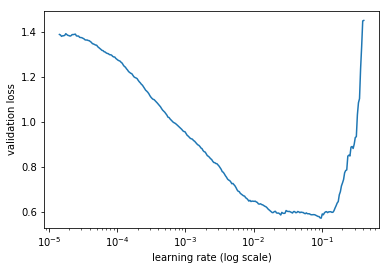

In [166]:
learn.lr_find(lrs/1000)
learn.sched.plot()

??? Mudar lr para 5 10 -1 (Borela)  

Rodamos o find e não alteramos rl depois ??

In [167]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 8/385 [00:02<02:06,  2.99it/s, loss=1.05]  


Exception in thread Thread-37:
Traceback (most recent call last):
  File "/home/borela/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/borela/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/borela/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.441217   0.313886   0.889971  

CPU times: user 58.6 s, sys: 23.9 s, total: 1min 22s
Wall time: 1min 22s


[array([0.31389]), 0.8899707856289716]

In [168]:
learn.save('clas_0')

In [169]:
learn.load('clas_0')

In [170]:
learn.freeze_to(-2)

In [171]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.372597   0.257151   0.90555   

CPU times: user 1min 10s, sys: 29.7 s, total: 1min 40s
Wall time: 1min 40s


[array([0.25715]), 0.9055501504092973]

In [172]:
learn.save('clas_1')

Passos para rexecução 

In [31]:
learn.load('clas_1')

In [32]:
learn.unfreeze()

Estava 24...
Reduzi para 16 (Borela)
variar

In [44]:
bs=8

# em caso de reexecução após load clas_1

em_sz=400 
nh = 1150 
nl=3
bptt=70
bs=4    # estourou memória out of memory : 16, 52
wd=1e-7
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)


drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.3

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]

In [47]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.322043   0.252854   0.907498  
    1      0.31987    0.253344   0.907498                    
    2      0.259365   0.190088   0.932814                    
    3      0.211837   0.166373   0.937683                    
    4      0.177007   0.168213   0.936709                    
    5      0.181295   0.156022   0.94742                     
    6      0.141055   0.150935   0.950341                    
    7      0.122673   0.148351   0.950341                    
    8      0.0851     0.15148    0.953262                     
    9      0.082571   0.139516   0.952288                     
    10     0.102657   0.146887   0.950341                     
    11     0.079494   0.142091   0.948393                     
    12     0.088254   0.137891   0.952288                     
    13     0.077607   0.141387   0.953262                     

CPU times: user 27min 29s, sys: 11min 50s, total: 39min 19s
Wall time: 39min 16s


[array([0.14139]), 0.9532619302089398]

<function matplotlib.pyplot.show>

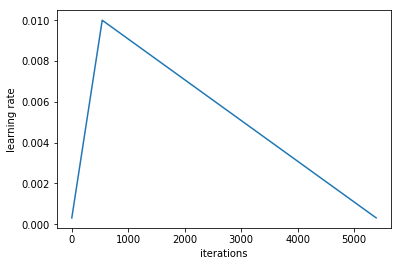

In [49]:
import matplotlib.pyplot as plt
plt.xlabel("iterations")
plt.ylabel("learning rate")
plt.plot(learn.sched.iterations, learn.sched.lrs)
plt.show

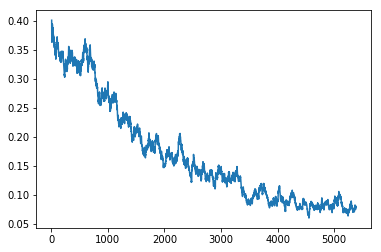

In [56]:
learn.sched.plot_loss()

In [57]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=7, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.100518   0.169843   0.951315  
    1      0.097744   0.153804   0.952288                     
    2      0.107056   0.156666   0.950341                     
    3      0.06696    0.156495   0.951315                     
    4      0.051846   0.162881   0.951315                     
    5      0.064159   0.136796   0.95813                      
    6      0.050371   0.14782    0.95813                      

CPU times: user 13min 4s, sys: 5min 39s, total: 18min 44s
Wall time: 18min 42s


[array([0.14782]), 0.9581304775240823]

In [58]:
learn.save('clas_2')

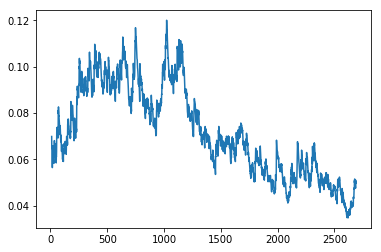

In [59]:
learn.sched.plot_loss()

The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).

## End